In [14]:
import numpy as np
import uproot as up 
import os 
import matplotlib.pyplot as plt
import yaml
import mplhep as hep

os.environ["DPUSER"] = '/work/submit/mori25/Darkphotons_ludo/'
DP_USER = os.environ.get("DPUSER", None)

def load_analysis_config():
    try:
        with open(os.path.join(DP_USER,"offline_analysis/config/analysis_config.yml"), "r") as f:
            config = yaml.load(f, Loader=yaml.FullLoader)
        return config
    except Exception as e: 
        raise e
    
config = load_analysis_config()

[362186.0, 373943.0, 371366.0, 373872.0]


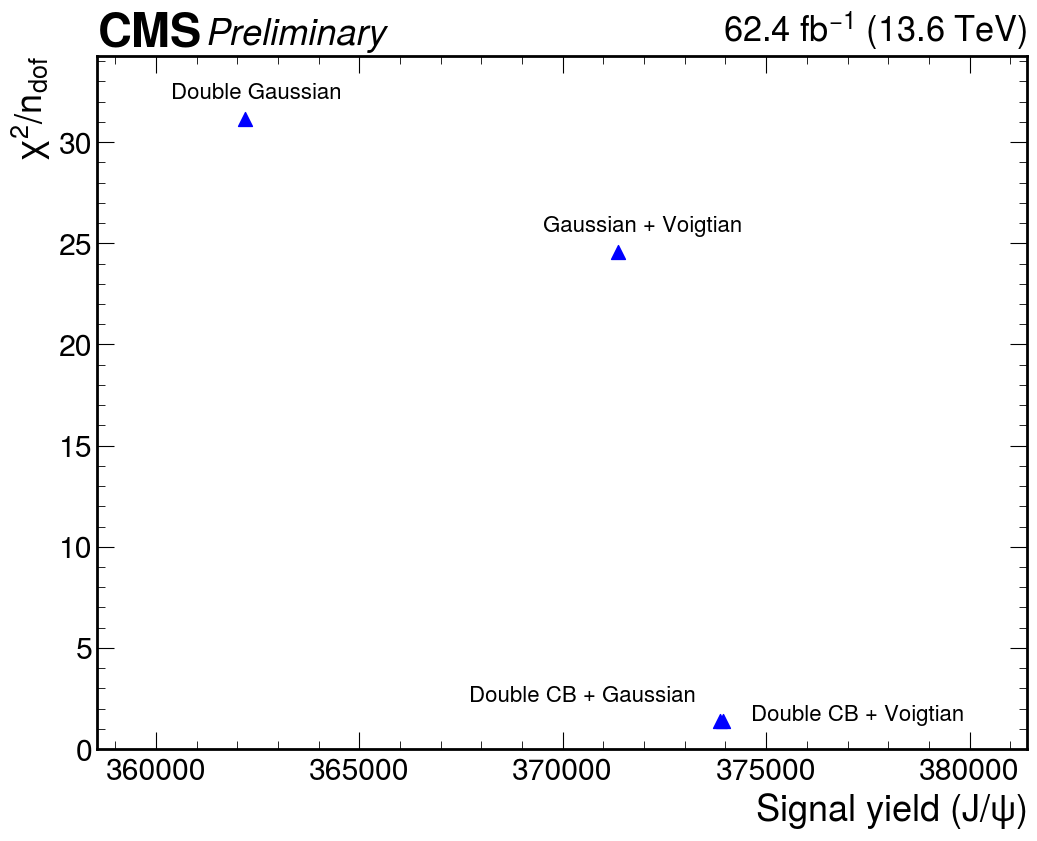

In [15]:
# Define the file name
path = os.path.join(config["locations"]["data"], "fits/models/")
file_names = ["dG", "dCB", "VG", "dCB_V", "dCB_V_var" ] [:-1]
labels = ["Double Gaussian", "Double CB + Gaussian", "Gaussian + Voigtian", "Double CB + Voigtian"]

# Initialize variables
sigYield = []
chisquare = []

for file_name in file_names:
    # Open the file and read the data
    with open(os.path.join(path,file_name+"_output.log"), 'r') as file:
        for line in file:
            if line.startswith('sigYield'):
                sigYield.append(float(line.split('=')[1]))
            elif line.startswith('chisquare'):
                chisquare.append(float(line.split('=')[1]))

# Check if the data was found
print(sigYield)
if sigYield is not None and chisquare is not None:
    hep.style.use("CMS")
    colors = plt.cm.tab10.colors
    fig, ax = plt.subplots(figsize=(12,9))
    hep.cms.label("Preliminary",data=True,lumi=config["lumi"]["offline"],com=config["com"])
    ax.scatter(sigYield, chisquare,marker = '^',s=100,c='blue')

    for i, txt in enumerate(labels):
        ax.annotate(txt, (sigYield[i]/(1.005+(i==1)*0.012 - (i==3)*0.007), chisquare[i]+(1.0 -  (i==3)*1.)),fontsize=16)

    # Add labels
    ax.set_xlabel('Signal yield (J/$\psi$)')
    ax.set_ylabel('$\chi^2/n_{dof}$')
    # ax.set_yscale('log')

    ax.set_xlim(0.99*min(sigYield), 1.02*max(sigYield))
    ax.set_ylim(0, 1.1*max(chisquare))


    # Show the plot
    plt.show()
else:
    print("Data not found in file.")

In [21]:
import re
# Define the file name
path = os.path.join(config["locations"]["data"], "fits/models/")
file_names = ["GdCB_var", "VdCB_var", "GdCB_fixReso", "VdCB_fixReso" ]
particles = ["Phi", "Jpsi", "Psi2","global"]
nflpars_tot = 27

flpars = ["GaussFraction","alphaL","alphaR","bkgDecayConst_Jpsi","bkgDecayConst_Phi","bkgDecayConst_Psi2","mu_Jpsi","mu_Phi","mu_Psi2","nL","nR","n_bkg_Jpsi","n_bkg_Phi","n_bkg_Psi2","n_signal_Jpsi","n_signal_Phi","n_signal_Psi2","q_Phi","q_Psi2","ql_Jpsi","ql_Phi","ql_Psi2","qr_Jpsi","qr_Phi","qr_Psi2","reso"]


results = {file_name: {p : {} for p in particles} for file_name in file_names}
for file_name in file_names: 
    with open(os.path.join(path, f"Multi_fit_output_{file_name}.log"), 'r') as file:
    # Read the contents of the file
        contents = file.read()
        pattern_test = r'total chisquare (\d+\.\d+)\nnbins :(\d+); nflpars : (\d+)\nchisquare/ndof=(\d+\.\d+)'
        matches_test = re.findall(pattern_test, contents)
        
        # Print the matches
        for match,p in zip(matches_test,particles):
            total_chisquare, nbins, nflpars, chisquare_ndof = match
            results[file_name][p]["nbins"] = int(nbins)
            results[file_name][p]["nflpars"] = int(nflpars)
            results[file_name][p]["chisquare_ndof"] = float(chisquare_ndof)
            results[file_name][p]["chisquare"] = float(chisquare_ndof)*(int(nbins)-int(nflpars))

    with open(os.path.join(path, f"Multi_fit_output_{file_name}.log"), 'r') as file:
        for line in file.readlines():
            parts = line.split()
            if len(parts)>0 and parts[0] in flpars:
                parameter = parts[0]
                final_value = parts[1] if len(parts)<=2 else parts[2]
                results[file_name]["global"][parameter] = float(final_value)        
print(results["GdCB_fixReso"]["global"])

{'q_Phi': 1.0, 'q_Psi2': 1.0, 'ql_Phi': 1.0, 'ql_Psi2': 1.0, 'qr_Phi': 1.0, 'qr_Psi2': 1.0, 'GaussFraction': 0.47224, 'alphaL': 2.0, 'alphaR': 2.0, 'bkgDecayConst_Jpsi': -1.4339, 'bkgDecayConst_Phi': 0.17452, 'bkgDecayConst_Psi2': -1.1259, 'mu_Jpsi': 3.1012, 'mu_Phi': 1.0184, 'mu_Psi2': 3.682, 'nL': 3.0, 'nR': 3.0, 'n_bkg_Jpsi': 28168.0, 'n_bkg_Phi': 32998.0, 'n_bkg_Psi2': 17911.0, 'n_signal_Jpsi': 114270.0, 'n_signal_Phi': 7825.7, 'n_signal_Psi2': 9529.5, 'ql_Jpsi': 1.2445, 'qr_Jpsi': 0.5, 'reso': 0.0095146}


In [26]:
for file_name in file_names:
    results[file_name]["global"]["chisquare"]= sum([results[file_name][p]["chisquare"] for p in particles[:-1]])
    results[file_name]["global"]["chisquare_ndof"]= results[file_name]["global"]["chisquare"]/nflpars_tot
    print(file_name, results[file_name]["global"]["chisquare"],results[file_name]["global"]["chisquare_ndof"])

GdCB_var 841.76337 31.17642111111111
VdCB_var 695.3438 25.753474074074074
GdCB_fixReso 1358.7606 50.324466666666666
VdCB_fixReso 346.44183 12.831178888888887


['red', 'blue']
0.0095146
['red', 'blue']
0.010497


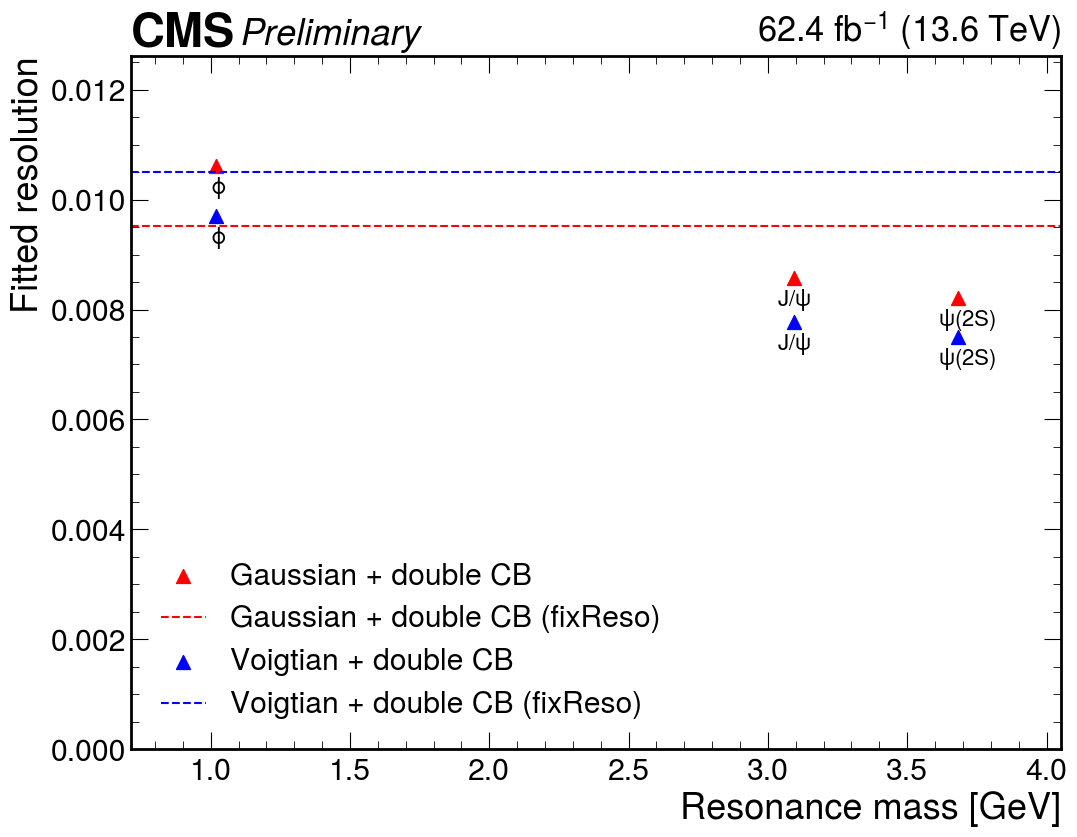

In [25]:
hep.style.use("CMS")
fig, ax = plt.subplots(figsize=(12,9))
hep.cms.label("Preliminary",data=True,lumi=config["lumi"]["offline"],com=config["com"])
labels = [r"$\phi$", r"J/$\psi$", r"$\psi(2S)$"]
colors= plt.cm.tab10.colors
colors=['red','blue']
models = ["Gaussian + double CB", "Voigtian + double CB"]

for u,file_name in enumerate(file_names[:2]):
    masses = [results[file_name]["global"]["mu_"+p] for p in ["Phi", "Jpsi", "Psi2"]]
    reso = results[file_name]["global"]["reso"]
    resolutions = [results[file_name]["global"]["q_Phi"] * reso, reso, results[file_name]["global"]["q_Psi2"] * reso ]
    ax.scatter(masses, resolutions,marker = '^',s=100,c=colors[u],label=models[u])
    print(colors)

    lims = (0.7*min(masses), 1.1*max(masses))
    fix_reso = results[file_name[:-4]+"_fixReso"]["global"]["reso"]
    ax.hlines(fix_reso, *lims,color=colors[u],linestyles='dashed',label=models[u]+" (fixReso)")
    print(fix_reso)

    for i, txt in enumerate(labels):
        ax.annotate(txt, (masses[i]/(1.02+(i==3)*0.03), resolutions[i]-0.0005),fontsize=16)

    ax.set_xlabel('Resonance mass [GeV]')
    ax.set_ylabel('Fitted resolution')
    # ax.set_yscale('log')
    ax.set_xlim(*lims)
    ax.set_ylim(0, 1.3*max(resolutions))
plt.legend(loc=3)
plt.show()